# Crzay World

There are 2 functions that change the engineer of Grid World:

## 1- grid.updtade_rewards()
         
after each episode change the palce of trap randomly
        
## 2- grid.off_on_rewards(it)
alternately in episodes, change value of trap block:

0: for even iteration

or

step_cost: for odd iteration

In [1]:
class CrazyGrid:
    def __init__(self, rows, cols, start):
        self.rows = rows
        self.cols = cols
        self.i = start[0]
        self.j = start[1]

    def set(self, rewards, actions):
        self.rewards = rewards
        self.actions = actions

    def set_points(self, step_cost, trap_point, trap):
        self.step_cost = step_cost
        self.trap_point = trap_point
        self.trap = trap

    def set_state(self, s):
        self.i = s[0]
        self.j = s[1]

    def current_state(self):
        return (self.i, self.j)

    def is_terminal(self, s):
        return s not in self.actions

    def get_next_state(self, s, a):
        i, j = s[0], s[1]
        if a in self.actions[(i, j)]:
            if a == 'S':
                return i, j
            if a == 'U':
                i -= 1
            elif a == 'D':
                i += 1
            elif a == 'R':
                j += 1
            elif a == 'L':
                j -= 1
        return i, j

    def move(self, action):
        if action in self.actions[(self.i, self.j)]:
            if action == 'S':
                pass
            if action == 'U':
                self.i -= 1
            elif action == 'D':
                self.i += 1
            elif action == 'R':
                self.j += 1
            elif action == 'L':
                self.j -= 1
        return self.rewards.get((self.i, self.j), 0)

    def game_over(self):
        return (self.i, self.j) not in self.actions

    def all_states(self):
        return set(self.actions.keys()) | set(self.rewards.keys())

    def updtade_rewards(self):
        grid.rewards[self.trap] = self.step_cost
        states = list(self.actions.keys())
        negative_idx = np.random.choice(len(states))
        grid.rewards.update({states[negative_idx]: self.trap_point})
        self.trap = states[negative_idx]

    def off_on_rewards(self, it):
        if it % 2 == 0:
            grid.rewards[self.trap] = self.step_cost
        else:
            grid.rewards[self.trap] = self.trap_point



In [2]:
def crazy_grid(step_cost = -0.1, trap_point= -10, trap = (3, 2)):
    game = CrazyGrid(5, 5, (0, 0))
    rewards = {(3, 4): 1}
    actions = {
        (0, 0): ('D', 'R', 'S'),
        (1, 0): ('U', 'D', 'S'),
        (2, 0): ('U', 'R', 'S'),  # 'D',
        # (3, 0): ('U', 'D', 'S'), # block for making a specific path
        (4, 0): ('R', 'S'),  # 'U',

        (0, 1): ('L', 'R', 'S'),
        # (1, 1): ('U', 'D', 'R'),
        (2, 1): ('L', 'R', 'S'),
        # (3, 1): ('L', 'R'),
        (4, 1): ('L', 'R', 'S'),

        (0, 2): ('D', 'L', 'S'),
        (1, 2): ('D', 'U', 'R', 'S'),
        (2, 2): ('D', 'U', 'L', 'S'),
        (3, 2): ('D', 'U', 'S'),   # trap
        (4, 2): ('U', 'L', 'R', 'S'),

        # (0, 3): ('D', 'L'),
        (1, 3): ('R', 'L', 'S'),
        # (2, 3): ('D', 'U'),
        (3, 3): ('R', 'L', 'D', 'S'),
        (4, 3): ('U', 'R', 'L', 'S'),

        (0, 4): ('D', 'S'),
        (1, 4): ('U', 'L', 'S'),
        # (2, 4): ('D', 'U', 'L', 'S'),
        # (3, 4): ('D'),  # terminal
        (4, 4): ('U', 'L', 'S'),
    }

    game.set(rewards, actions)
    game.set_points(step_cost, trap_point, trap) 
    
    visitable_states = actions.keys()
    for s in visitable_states:
        game.rewards[s] = step_cost

    game.rewards[trap] = trap_point
    return game

# Define Extra functions

In [3]:
def print_values(V, g):
    for i in range(g.rows):
        print("---------------------------")
        for j in range(g.cols):
            v = V.get((i, j), 0)
            if v >= 0:
                print(" %.2f|" % v, end="")
            else:
                print("%.2f|" % v, end="")  # -ve sign takes up an extra space
        print("")


def print_policy(P, g):
    for i in range(g.rows):
        print("---------------------------")
        for j in range(g.cols):
            a = P.get((i, j), ' ')
            print("  %s  |" % a, end="")
        print("")
        
def print_world(g):
    for i in range(g.rows):
        print("--------------------------------------------------")
        for j in range(g.cols):
            if (i, j) == (0, 0):
                print("  Start  |", end="")
            elif (i, j) == (3, 2):
                print("  Trap   |", end="")
            elif (i, j) == (3, 4):
                print("  Term.  |", end="")
            elif (i, j) not in g.actions.keys():
                print("  Wall   |", end="")
            else:              
                print("         |", end="")
        print("")

In [4]:
def random_action(a, eps=0.1):
    # we'll use epsilon-soft to ensure all states are visited
    # what happens if you don't do this? i.e. eps=0
    p = np.random.random()
    if p < (1 - eps):
        return a
    else:
        return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [5]:
def max_dict(d):
    # returns the argmax (key) and max (value) from a dictionary
    # put this into a function since we are using it so often
    max_key = None
    max_val = float('-inf')
    for k, v in d.items():
        if v > max_val:
            max_val = v
            max_key = k
    return max_key, max_val

# Find Optimal Policy For Crazy Grid World      

In [6]:
import numpy as np
import matplotlib.pyplot as plt

GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R', 'S')

## Play Game for grid.updtade_rewards()

first episode of grid world:
--------------------------------------------------
  Start  |         |         |  Wall   |         |
--------------------------------------------------
         |  Wall   |         |         |         |
--------------------------------------------------
         |         |         |  Wall   |  Wall   |
--------------------------------------------------
  Wall   |  Wall   |  Trap   |         |  Term.  |
--------------------------------------------------
         |         |         |         |         |
rewards:
---------------------------
-0.10|-0.10|-0.10| 0.00|-0.10|
---------------------------
-0.10| 0.00|-0.10|-0.10|-0.10|
---------------------------
-0.10|-0.10|-0.10| 0.00| 0.00|
---------------------------
 0.00| 0.00|-10.00|-0.10| 1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|-0.10|


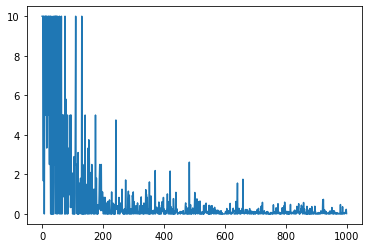

rewards:
---------------------------
-0.10|-10.00|-0.10| 0.00|-0.10|
---------------------------
-0.10| 0.00|-0.10|-0.10|-0.10|
---------------------------
-0.10|-0.10|-0.10| 0.00| 0.00|
---------------------------
 0.00| 0.00|-0.10|-0.10| 1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|-0.10|
final policy:
---------------------------
  R  |  L  |  D  |     |  D  |
---------------------------
  U  |     |  U  |  L  |  U  |
---------------------------
  R  |  R  |  U  |     |     |
---------------------------
     |     |  D  |  R  |     |
---------------------------
  R  |  R  |  R  |  R  |  U  |
final values:
---------------------------
-4.14|-4.37|-2.86| 0.00|-4.50|
---------------------------
-3.94| 0.00|-2.84|-4.78|-4.51|
---------------------------
-4.49|-2.96|-2.91| 0.00| 0.00|
---------------------------
 0.00| 0.00|-2.97| 1.00| 0.00|
---------------------------
-4.88|-4.19|-1.83|-0.95| 1.00|


In [7]:

def play_game(grid, policy):
    # returns a list of states and corresponding returns

    # reset game to start at a random position
    # we need to do this if we have a deterministic policy
    # we would never end up at certain states, but we still want to measure their value
    # this is called the "exploring starts" method
    start_states = list(grid.actions.keys())
    start_idx = np.random.choice(len(start_states))
    grid.set_state(start_states[start_idx])

    s = grid.current_state()
    a = np.random.choice(ALL_POSSIBLE_ACTIONS)  # first action is uniformly random

    # be aware of the timing
    # each triple is s(t), a(t), r(t)
    # but r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
    states_actions_rewards = [(s, a, 0)]
    seen_states = set()
    seen_states.add(grid.current_state())
    num_steps = 0
    while True:
        r = grid.move(a)
        num_steps += 1
        s = grid.current_state()

        if s in seen_states:
            # hack so that we don't end up in an infinitely long episode
            # bumping into the wall repeatedly
            # if num_steps == 1 -> bumped into a wall and haven't moved anywhere
            #   reward = -10
            # else:
            #   reward = falls off by 1 / num_steps
            reward = -10. / num_steps
            states_actions_rewards.append((s, None, reward))
            break
        elif grid.game_over():
            states_actions_rewards.append((s, None, r))
            break
        else:
            a = policy[s]
            states_actions_rewards.append((s, a, r))
        seen_states.add(s)
        grid.updtade_rewards()
        # grid.off_on_rewards(it)

    # calculate the returns by working backwards from the terminal state
    G = 0
    states_actions_returns = []
    first = True
    for s, a, r in reversed(states_actions_rewards):
        if first:
            first = False
        else:
            states_actions_returns.append((s, a, G))
        G = r + GAMMA * G
    states_actions_returns.reverse()  # we want it to be in order of state visited
    return states_actions_returns


if __name__ == '__main__':
    grid = crazy_grid()
    print("first episode of grid world:")
    print_world(grid)
    print("rewards:")
    print_values(grid.rewards, grid)

    # initialize a random policy
    policy = {}
    for s in grid.actions.keys():
        policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

    # initialize Q(s,a) and returns
    Q = {}
    returns = {}  # dictionary of state -> list of returns we've received
    states = grid.all_states()
    for s in states:
        if s in grid.actions:  # not a terminal state
            Q[s] = {}
            for a in ALL_POSSIBLE_ACTIONS:
                Q[s][a] = 0  # needs to be initialized to something so we can argmax it
                returns[(s, a)] = []
        else:
            # terminal state or state we can't otherwise get to
            pass

    # repeat until convergence
    deltas = []
    for t in range(1000):
        # generate an episode using pi
        biggest_change = 0
        states_actions_returns = play_game(grid, policy)
        seen_state_action_pairs = set()
        for s, a, G in states_actions_returns:
            # check if we have already seen s
            # called "first-visit" MC policy evaluation
            sa = (s, a)
            if sa not in seen_state_action_pairs:
                old_q = Q[s][a]
                returns[sa].append(G)
                Q[s][a] = np.mean(returns[sa])
                biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
                seen_state_action_pairs.add(sa)
        deltas.append(biggest_change)

        # update policy
        for s in policy.keys():
            policy[s] = max_dict(Q[s])[0]

    plt.plot(deltas)
    plt.show()
    print("rewards:")
    print_values(grid.rewards, grid)
    print("final policy:")
    print_policy(policy, grid)

    # find V
    V = {}
    for s, Qs in Q.items():
        V[s] = max_dict(Q[s])[1]

    print("final values:")
    print_values(V, grid)

## Play Game for grid.off_on_rewards(it)

first episode of grid world:
--------------------------------------------------
  Start  |         |         |  Wall   |         |
--------------------------------------------------
         |  Wall   |         |         |         |
--------------------------------------------------
         |         |         |  Wall   |  Wall   |
--------------------------------------------------
  Wall   |  Wall   |  Trap   |         |  Term.  |
--------------------------------------------------
         |         |         |         |         |
rewards:
---------------------------
-0.10|-0.10|-0.10| 0.00|-0.10|
---------------------------
-0.10| 0.00|-0.10|-0.10|-0.10|
---------------------------
-0.10|-0.10|-0.10| 0.00| 0.00|
---------------------------
 0.00| 0.00|-10.00|-0.10| 1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|-0.10|


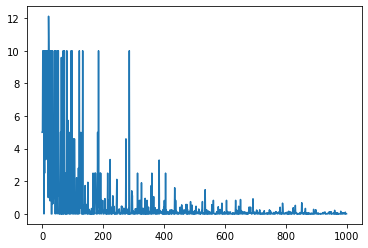

rewards:
---------------------------
-0.10|-0.10|-0.10| 0.00|-0.10|
---------------------------
-0.10| 0.00|-0.10|-0.10|-0.10|
---------------------------
-0.10|-0.10|-0.10| 0.00| 0.00|
---------------------------
 0.00| 0.00|-10.00|-0.10| 1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|-0.10|
final policy:
---------------------------
  R  |  R  |  D  |     |  D  |
---------------------------
  U  |     |  D  |  L  |  L  |
---------------------------
  U  |  L  |  L  |     |     |
---------------------------
     |     |  D  |  R  |     |
---------------------------
  R  |  R  |  R  |  R  |  U  |
final values:
---------------------------
-1.63|-1.54|-1.34| 0.00|-2.57|
---------------------------
-1.56| 0.00|-1.57|-2.29|-2.79|
---------------------------
-1.47|-1.57|-1.51| 0.00| 0.00|
---------------------------
 0.00| 0.00|-0.87| 1.00| 0.00|
---------------------------
-2.87|-1.63| 0.04| 0.31| 1.00|


In [8]:

def play_game(grid, policy, it):
    # returns a list of states and corresponding returns

    # reset game to start at a random position
    # we need to do this if we have a deterministic policy
    # we would never end up at certain states, but we still want to measure their value
    # this is called the "exploring starts" method
    start_states = list(grid.actions.keys())
    start_idx = np.random.choice(len(start_states))
    grid.set_state(start_states[start_idx])

    s = grid.current_state()
    a = np.random.choice(ALL_POSSIBLE_ACTIONS)  # first action is uniformly random

    # be aware of the timing
    # each triple is s(t), a(t), r(t)
    # but r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
    states_actions_rewards = [(s, a, 0)]
    seen_states = set()
    seen_states.add(grid.current_state())
    num_steps = 0
    while True:
        r = grid.move(a)
        num_steps += 1
        s = grid.current_state()

        if s in seen_states:
            # hack so that we don't end up in an infinitely long episode
            # bumping into the wall repeatedly
            # if num_steps == 1 -> bumped into a wall and haven't moved anywhere
            #   reward = -10
            # else:
            #   reward = falls off by 1 / num_steps
            reward = -10. / num_steps
            states_actions_rewards.append((s, None, reward))
            break
        elif grid.game_over():
            states_actions_rewards.append((s, None, r))
            break
        else:
            a = policy[s]
            states_actions_rewards.append((s, a, r))
        seen_states.add(s)
        # grid.updtade_rewards()
        grid.off_on_rewards(it)

    # calculate the returns by working backwards from the terminal state
    G = 0
    states_actions_returns = []
    first = True
    for s, a, r in reversed(states_actions_rewards):
        if first:
            first = False
        else:
            states_actions_returns.append((s, a, G))
        G = r + GAMMA * G
    states_actions_returns.reverse()  # we want it to be in order of state visited
    return states_actions_returns


if __name__ == '__main__':
    grid = crazy_grid()
    print("first episode of grid world:")
    print_world(grid)
    print("rewards:")
    print_values(grid.rewards, grid)

    # initialize a random policy
    policy = {}
    for s in grid.actions.keys():
        policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

    # initialize Q(s,a) and returns
    Q = {}
    returns = {}  # dictionary of state -> list of returns we've received
    states = grid.all_states()
    for s in states:
        if s in grid.actions:  # not a terminal state
            Q[s] = {}
            for a in ALL_POSSIBLE_ACTIONS:
                Q[s][a] = 0  # needs to be initialized to something so we can argmax it
                returns[(s, a)] = []
        else:
            # terminal state or state we can't otherwise get to
            pass

    # repeat until convergence
    deltas = []
    for t in range(1000):
        # generate an episode using pi
        biggest_change = 0
        states_actions_returns = play_game(grid, policy, t)
        seen_state_action_pairs = set()
        for s, a, G in states_actions_returns:
            # check if we have already seen s
            # called "first-visit" MC policy evaluation
            sa = (s, a)
            if sa not in seen_state_action_pairs:
                old_q = Q[s][a]
                returns[sa].append(G)
                Q[s][a] = np.mean(returns[sa])
                biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
                seen_state_action_pairs.add(sa)
        deltas.append(biggest_change)

        # update policy
        for s in policy.keys():
            policy[s] = max_dict(Q[s])[0]

    plt.plot(deltas)
    plt.show()
    print("rewards:")
    print_values(grid.rewards, grid)
    
    print("final policy:")
    print_policy(policy, grid)

    # find V
    V = {}
    for s, Qs in Q.items():
        V[s] = max_dict(Q[s])[1]

    print("final values:")
    print_values(V, grid)